<a href="https://colab.research.google.com/github/araujocdebora/Machine-Learning-with-Python/blob/master/RF_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DV dataset: './Datasets/DV/gender_bias.txt'
1: offensive
2: neither
0: hateful

In [1]:
# Utils
import re
import pandas as pd
import numpy as np
import unicodedata
from tqdm.auto import tqdm
import time
import timeit

start = timeit.default_timer()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataframe = pd.read_csv('/content/drive/MyDrive/Jupyter/Doutorado/Tese/2022/Datasets/DV/gender_bias.txt')
dataframe.reset_index(drop=True, inplace=True)
dataframe.head(2)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...


In [4]:
dataframe['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

# Padronizando dataset

In [5]:
data = dataframe.filter(['tweet','class'])
data = data.rename(columns={'tweet': 'text', 'class': 'label'})
data.head()

,text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [6]:
data = data[data.label != 0]
data['label'].value_counts()

1    19190
2     4163
Name: label, dtype: int64

# Pré-processamento

In [9]:
import nltk
import re

from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def stopwords_remove(instancia):
    
    #remove caracteres especiais
    instancia = re.sub(r"http\S+", " ", instancia).lower().replace(',',' ').replace('.',
            ' ').replace(';',' ').replace('-',' ').replace('(', ' ').replace(')', ' ').replace('  ', ' ')
    
    instancia = instancia = re.sub(r'https\s+|www.\s+', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'http\s+|www.\s+', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'\s+[a-zA-Z]\s+', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'\^[a-zA-Z]\s+', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'\s+', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r"[0-9]", " digit ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'[?|!|\'|"|#]', " ", instancia).lower().replace('  ',' ')
    instancia = instancia = re.sub(r'[.|,|)|(|\|/]', " ", instancia).lower().replace('  ',' ')
    
    instancia = re.sub('\[.*?\]', ' ', instancia)
    instancia = re.sub('\w*\d\w*', ' ', instancia)
    instancia = re.sub('[‘’“”…]', ' ', instancia)
    instancia = re.sub('\n', ' ', instancia)
    
    #remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    
    return (" ".join(palavras))

def stemming_applied(instancia):
    
    palavras=[]
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    
    return (" ".join(palavras))

In [11]:
new_data = []
for i in data['text']:
    
    texto = stopwords_remove(i)
    texto = stemming_applied(texto)
    
    new_data.append(texto)
    
data['text'] = new_data
data.head()

,text,label
0,rt @mayasolovely: woman complain clean hous &a...,2
1,rt @mleew digit digit : boy dat cold tyga dwn ...,1
2,rt @urkindofbrand dawg rt @ digit digit sbabi ...,1
3,rt @c_g_anderson: @viva_bas look like tranni,1
4,rt @shenikaroberts: shit hear might true might...,1


# Identificador de comentários que contém termos de identidade

In [12]:
list_term = ['woman', 'women', 'girl', 'sister', 'daughter', 'wife', 'girlfriend', 'mother', 'aunt', 'mom', 'grandmother', 'femal']

identificador = []
for index,sentence in enumerate(data['text']):
    for word in sentence.split():
        if word in list_term:
            identificador.append(index)
            break

column_identify = []
for index,sentence in enumerate(data['text']):
    if index in identificador:
        column_identify.append(1)
    else:
        column_identify.append(0)
data['column_identify_term'] = column_identify
data['id'] = data.index
data.head()

,text,label,column_identify_term,id
0,rt @mayasolovely: woman complain clean hous &a...,2,1,0
1,rt @mleew digit digit : boy dat cold tyga dwn ...,1,0,1
2,rt @urkindofbrand dawg rt @ digit digit sbabi ...,1,0,2
3,rt @c_g_anderson: @viva_bas look like tranni,1,0,3
4,rt @shenikaroberts: shit hear might true might...,1,0,4


# Random Forest

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, metrics, svm
from sklearn.utils import shuffle

In [16]:
!pip install zeugma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for zeugma: filename=zeugma-0.49-py3-none-any.whl size=8823 sha256=b9c5b7ff534557c5d8694d7fdc592df7659bfe391ab19c6684c928510294deb2
  Stored in directory: /root/.cache/pip/wheels/1d/47/5b/2a59a79706cc9340c72fd6a7bfc20e7ebcab849c88c38fdfa0
Successfully built zeugma


In [17]:
import warnings
from zeugma.embeddings import EmbeddingTransformer
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import sys
import os

In [18]:
X = data['text'] 
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [19]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    print("Precision Score of the model:", precision_score(y_test,predictions)*100)
    print("Recall Score of the model:", recall_score(y_test,predictions)*100)
    print("Acuracy score of the model:",accuracy_score(y_test,predictions)*100)
    print("F1 score of the model:",f1_score(y_test,predictions)*100)

In [20]:
corpus_train = X_train
corpus_test = X_test

In [21]:
glove_twitter = EmbeddingTransformer('glove-twitter-200') 

[==================================================] 100.0% 758.5/758.5MB downloaded


In [22]:
x_train_twitter = glove_twitter.transform(corpus_train) 
x_test_twitter = glove_twitter.transform(corpus_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Precision Score of the model: 94.8870392390012
Recall Score of the model: 97.02970297029702
Acuracy score of the model: 93.26291749928632
F1 score of the model: 95.94641016832703


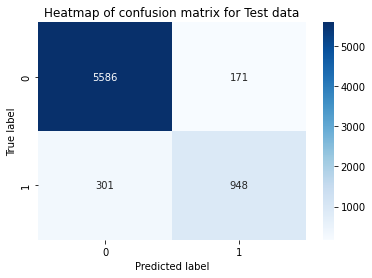

In [23]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(x_train_twitter, y_train)
predictions = model_lr.predict(x_test_twitter)
evaluate(y_test, predictions)